## Purpose

I want to know if oversampling a signal helps it's time resolution.

## How do we test this?

Start with a bandlimited signal and see how well we can sample an event in this signal with a higher bandwidth receiver. Assume no time-synchronization between transmision and reception (add a random sample and phase offset). Use different startegies to identify the event

**Sample event:** Phase is $\pi/2$ on two sine waves.  
**Event detection startegy 1:** A global maxima corresponds to the event.  
**Event detection startegy 2:** Match filter around a neighbourhood of the signal.

Useful trigonometric formulae

$$sin(a) \pm sin(b) = 2 sin\left(\frac{a\pm b}{2}\right) cos\left(\frac{a \mp b}{2}\right)$$
$$cos(a) + cos(b) = 2 cos\left(\frac{a + b}{2}\right) cos\left(\frac{a - b}{2}\right)$$
$$cos(a) - cos(b) = - 2 sin\left(\frac{a + b}{2}\right) sin\left(\frac{a - b}{2}\right)$$

# Questions to be answered

### Q. Does oversampling matter? \[test with combination of sines\]

Nyquist sampling theorem still holds even with oversampling. What does that mean? A signal of limited bandwidth can be perfectly recreated (including it's timings) if we have samples at Nyquist rate or higher.

This recreation can get confused in the presence of noise. In that sense, oversampling helps timing acquisition because it ends up with better SNR.

### Q. How do we timestamp a chirp based-waveform? \[test with a single chirp waveform\]

Multiply by a downchirp (not convolve! convolution would be like a matched filter) and check for constant frequency regions

Q. What if the signal is not time synchronized?

Q. What if the signal is not frequency synchronized?

### Q. Combining multi-frequency measurements?

Still no idea about how interpolation would actually happen

### Q. How does L0 sync affect timing?

In [1]:
# use fancy zoomable plotting
%matplotlib notebook

# use standard plotting
# %matplotlib inline

## Initial tests with a combination of sinusoidal waves

<IPython.core.display.Javascript object>


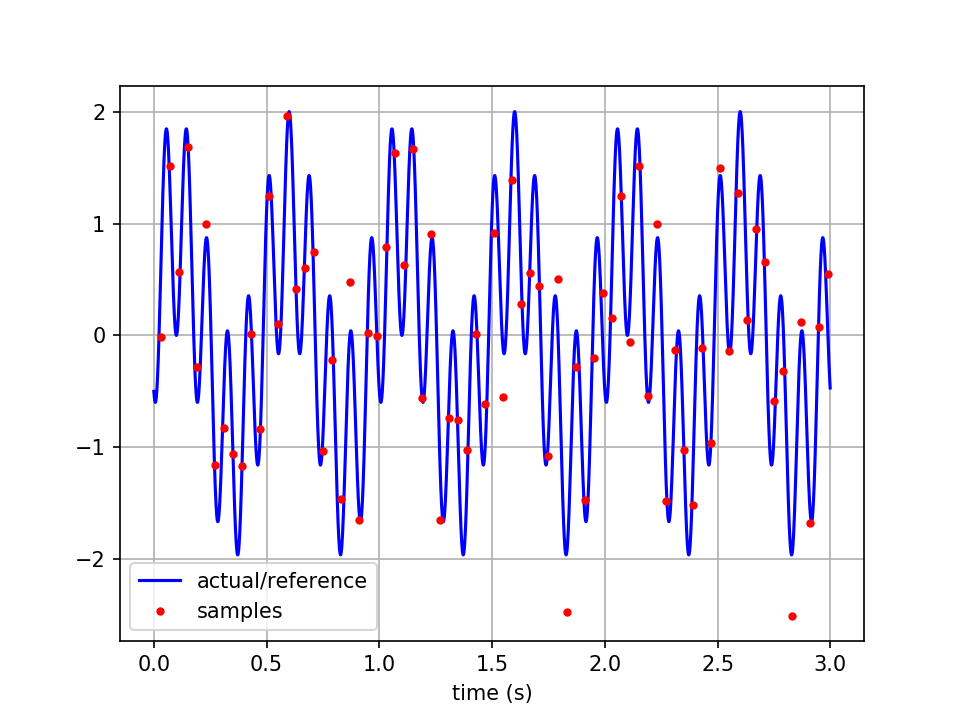

<IPython.core.display.Javascript object>


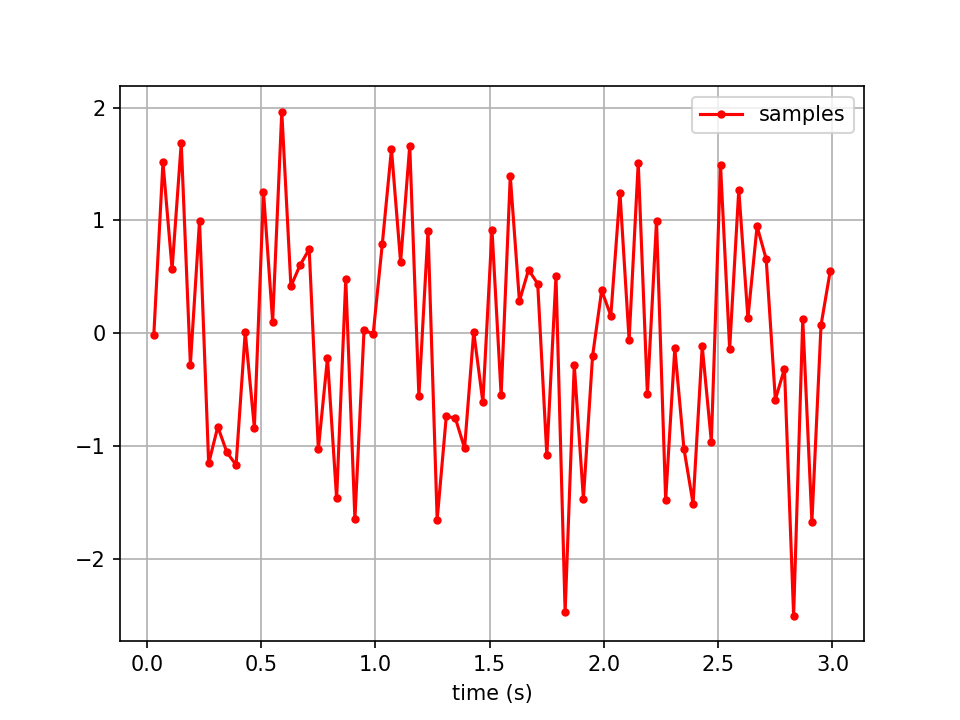

<IPython.core.display.Javascript object>


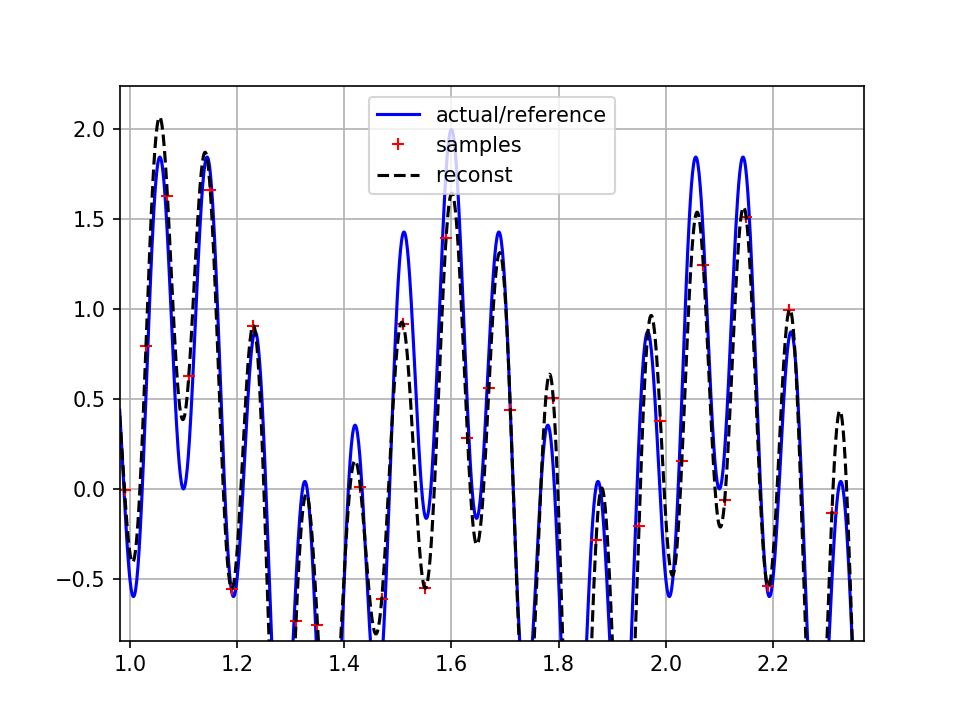

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

def timesOffset(start, stop, step, offset=0.0, returnStart=False):
    # create a series of times from start+offset to stop+offet (not included) at the specified step size
    # this is useful to quickly generate a time series with a sampling offset and different sampling rate
    
    if returnStart:
        return np.arange(start+offset, stop+offset, step), start+offset
    else:
        return np.arange(start+offset, stop+offset, step)

def cosAligned(times, f, t0 = 0.0, phi0 = 0.0):
    # generate a cosine wave. the phase will be phi0 at time t0.
    x = np.cos(2*np.pi*f*(times - t0) + phi0)
    return x


def sinAligned(times, f, t0 = 0.0, phi0 = 0.0):
    # generate a sine wave. the phase will be phi0 at time t0.
    x =  np.sin(2*np.pi*f*(times - t0) + phi0)
    return x

# simulation params
tStart = 0.0
tEnd = 3.0
tsRef = 0.001
tsSample = 0.04

eventOffset = 0.6  # what time does the (first) event take place
samplingOffset = 0.03  # what is the offset of the sampling clock
noiseStd = 0.3
f1 = 2.0  # lowest frequency to use for simulation
f2 = 11.0  # highest frequency to use for simulation

if 2*max(f1, f2) >= 1/tsSample:
    raise RuntimeWarning("sinusoid sampling rate is lower than nyquist rate")

np.random.seed(100)  # initialize random seed for repeatibility

# original signals (reference)
tR = timesOffset(tStart, tEnd, tsRef)  # reference time series
s = (cosAligned(tR, f1, t0=eventOffset)
     + cosAligned(tR, f2, t0=eventOffset)
    )

# sampled signal with some noise
tS = timesOffset(tStart, tEnd, tsSample, offset=samplingOffset)  # sample time series
sS = (cosAligned(tS, f1, t0=eventOffset)
      + cosAligned(tS, f2, t0=eventOffset)
      + np.random.normal(0.0, noiseStd, size=tS.shape)
     )

# attempt to reconstruct the original signal using just the samples we collected
sReconst = sig.resample(sS, s.shape[0])

# plot original signal and sampled version
plt.figure()
plt.plot(tR, s, 'b-', label="actual/reference")
plt.plot(tS, sS, 'r.', label="samples")
plt.xlabel("time (s)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(tS, sS, 'r.-', label="samples")
plt.xlabel("time (s)")
plt.grid()
plt.legend()

# plot reconstruction
plt.figure()
plt.plot(tR, s, 'b-', label="actual/reference")
plt.plot(tS, sS, 'r+', label="samples")
plt.plot(tR+samplingOffset, sReconst, 'k--', label="reconst")
plt.grid()
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


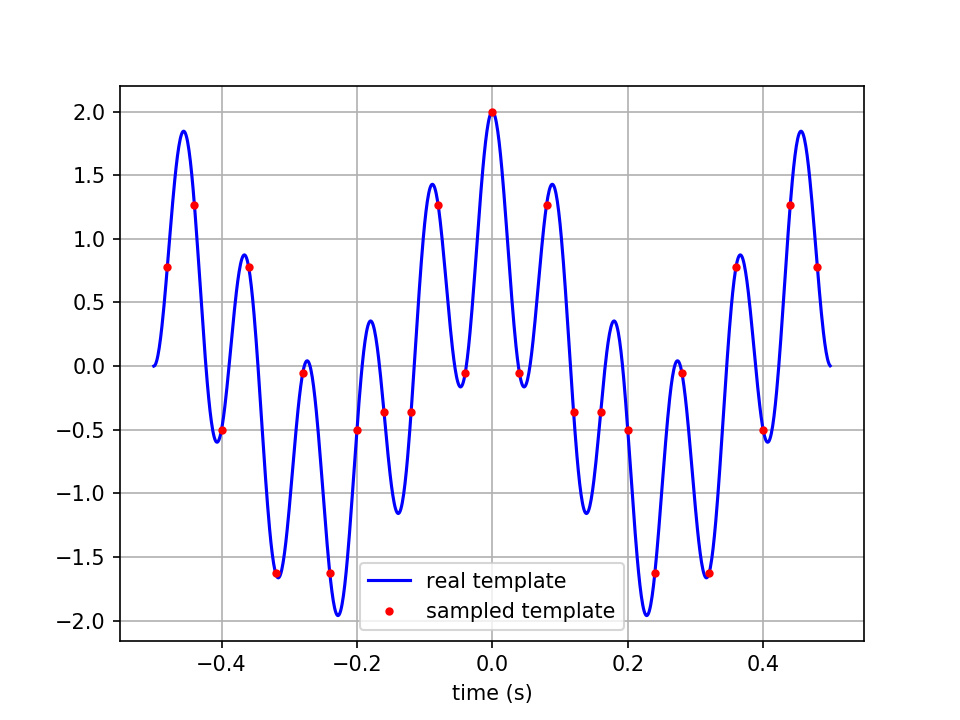

<IPython.core.display.Javascript object>


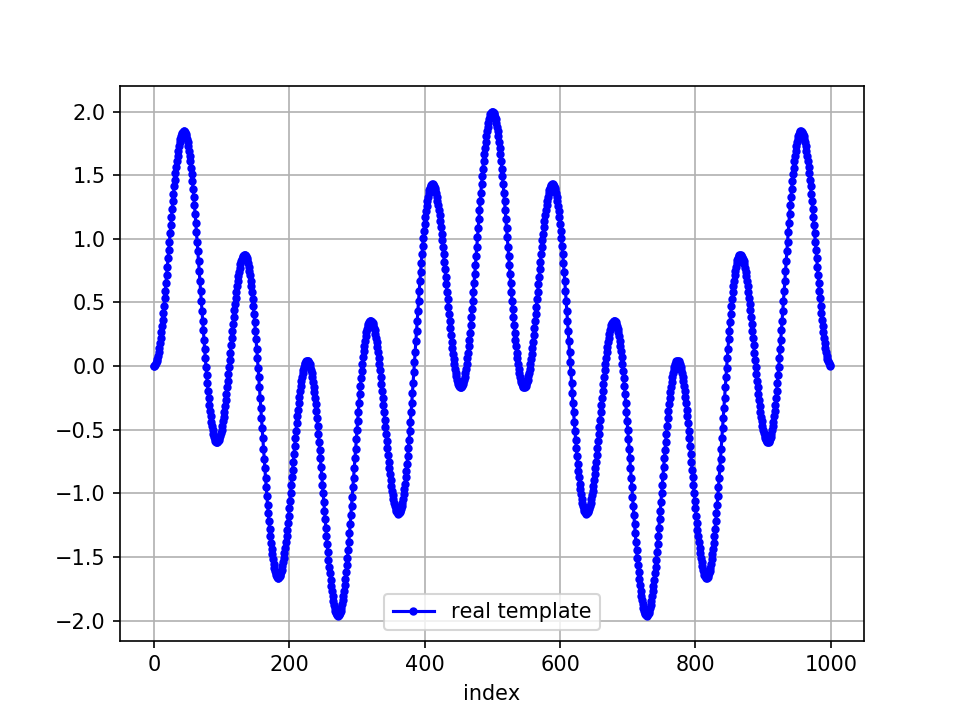

<IPython.core.display.Javascript object>


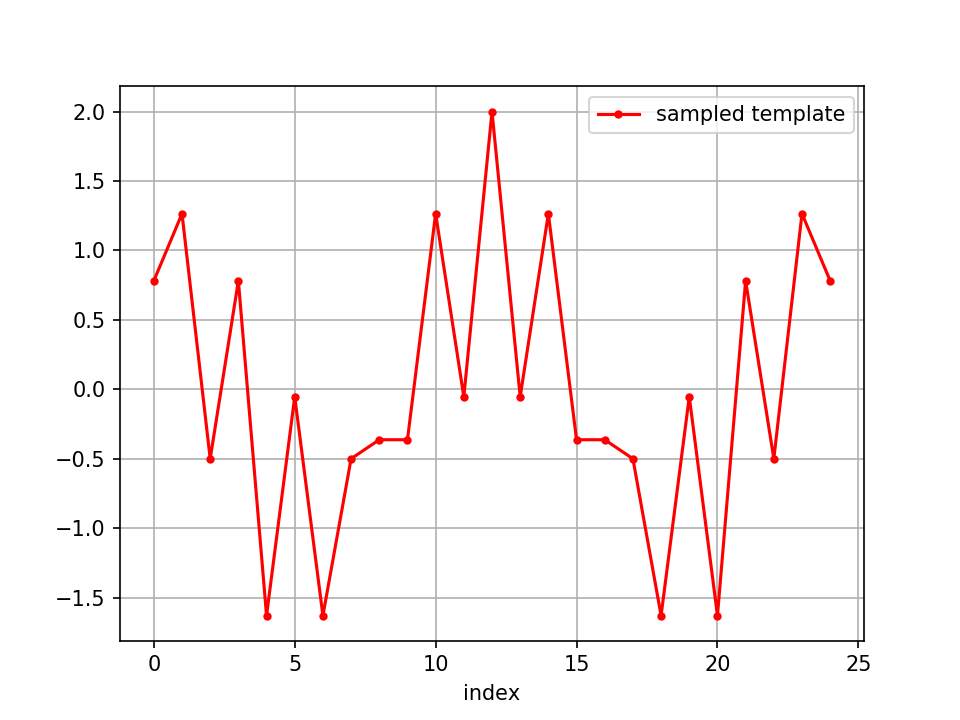

In [5]:
# create templates to compare the original signal against

# ideal template (reference)
tI = timesOffset(-0.5, 0.5, 0.001)
sTemp = cosAligned(tI, f1) + cosAligned(tI, f2)

# ideal template (sampled)
tSI = timesOffset(-0.5, 0.5, 0.04, offset=0.02)
sSTemp = cosAligned(tSI, 2.0) + cosAligned(tSI, 11.0)

# plot signal template and sampled template
plt.figure()
plt.plot(tI, sTemp, 'b-', label="real template")
plt.plot(tSI, sSTemp, 'r.', label="sampled template")
plt.xlabel("time (s)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(sTemp, 'b.-', label="real template")
plt.grid()
plt.xlabel("index")
plt.legend()


plt.figure()
plt.plot(sSTemp, 'r.-', label="sampled template")
plt.grid()
plt.xlabel("index")
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


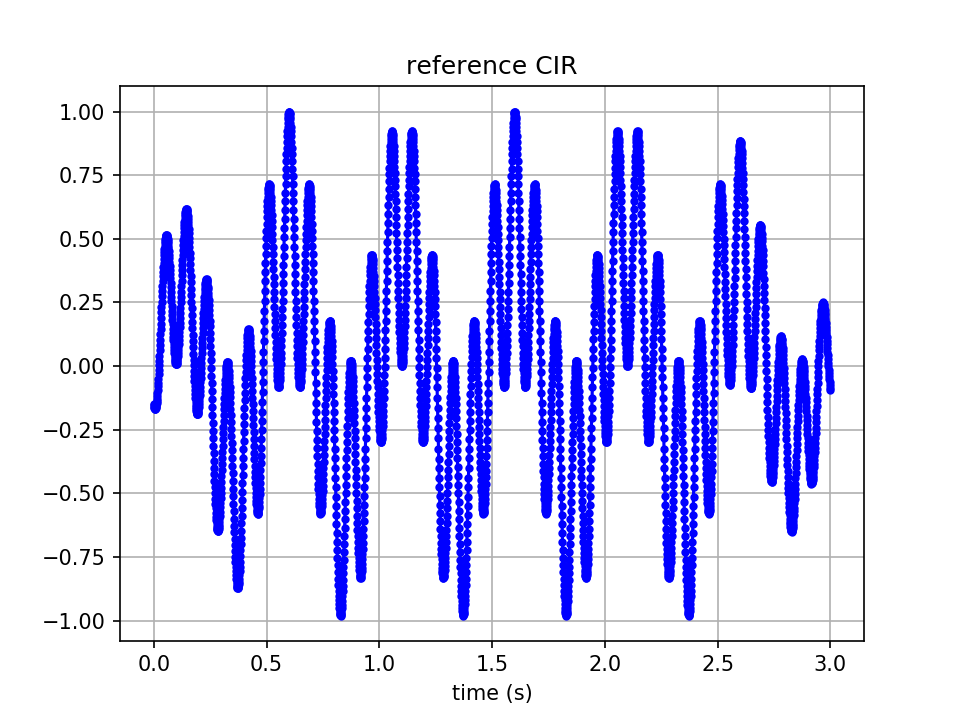

<IPython.core.display.Javascript object>


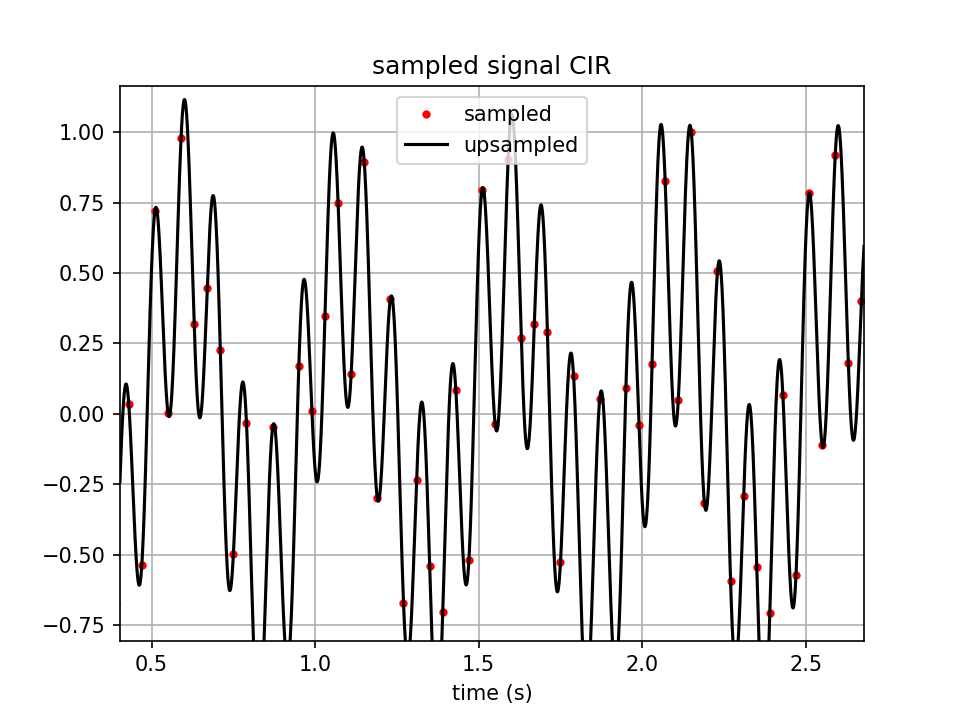

<IPython.core.display.Javascript object>


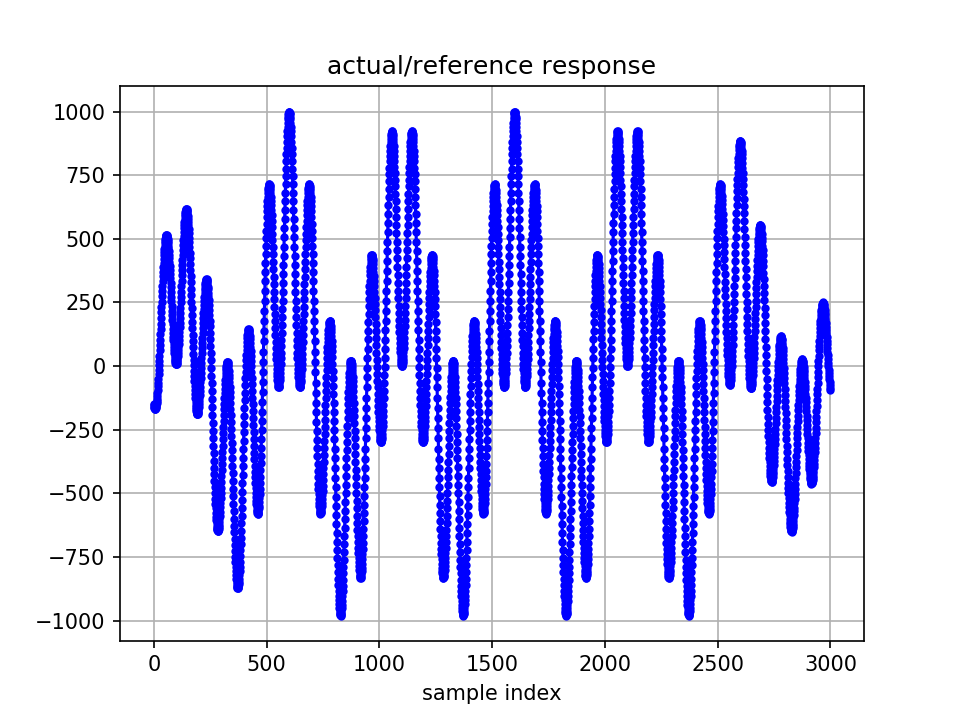

<IPython.core.display.Javascript object>


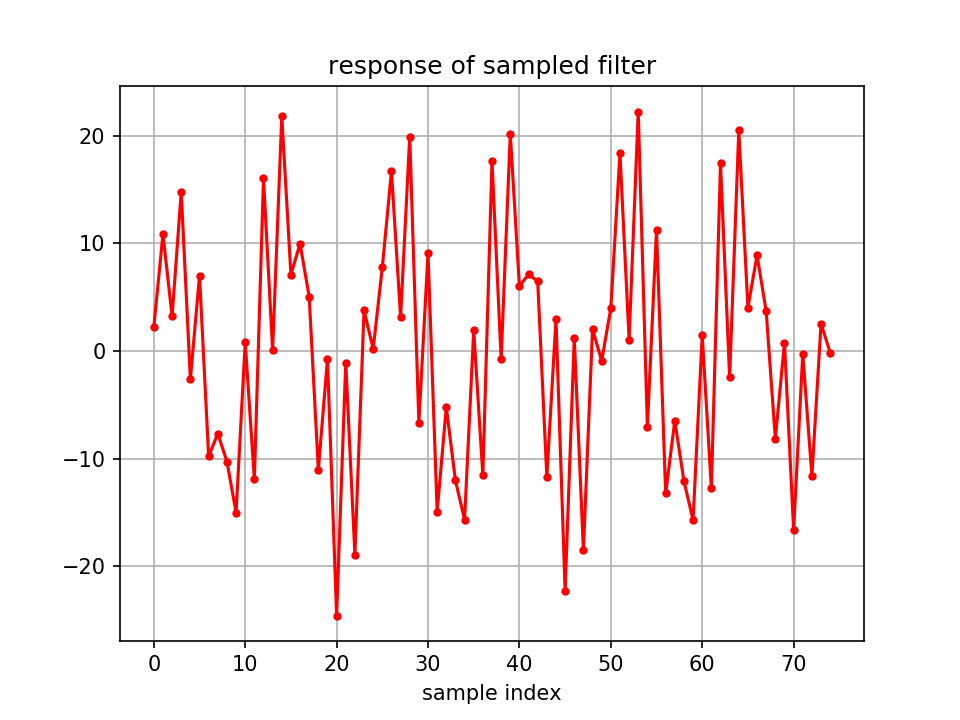

<IPython.core.display.Javascript object>


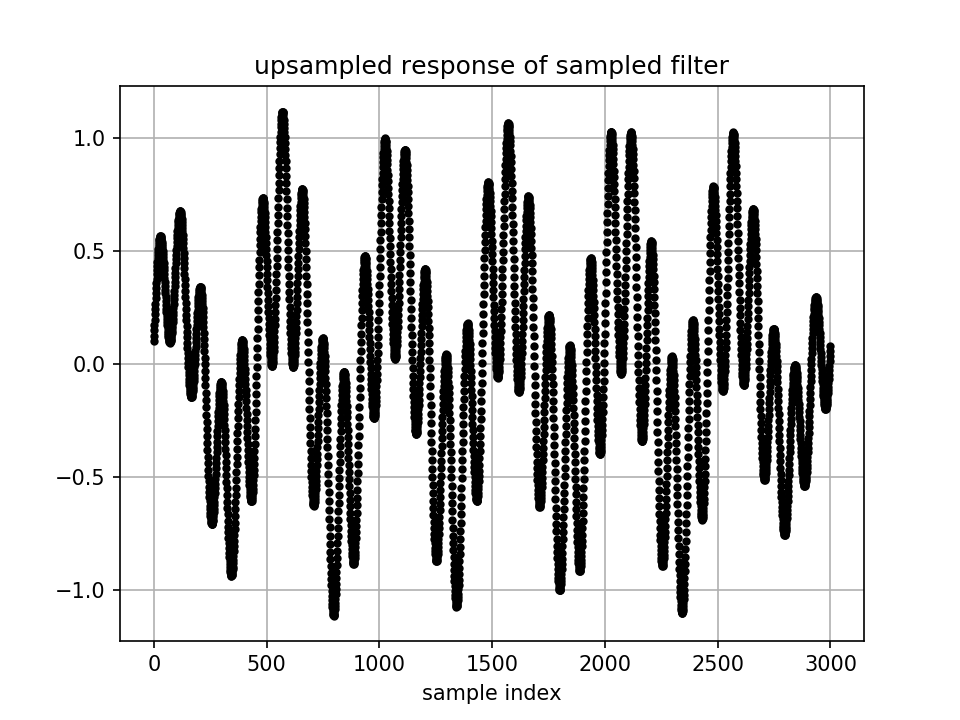

In [6]:
# match filter the received signal using the generated template

cr = np.convolve(s, np.flipud(sTemp), mode='same')
crNorm = np.divide(cr, np.max(cr))  # normalize result
crS = np.convolve(sS, np.flipud(sSTemp), mode='same')
crSNorm = np.divide(crS, np.max(crS))  # normalize result
crUP = sig.resample(crS, cr.shape[0])  # upsample the sampled filter result
crUPNorm = np.divide(crUP, np.max(crS))  # normalize reconstructed result

plt.figure()
plt.title("reference CIR")
plt.plot(tR, crNorm, 'b.-', label="complete")
plt.grid()
plt.xlabel("time (s)")

plt.figure()
plt.title("sampled signal CIR")
plt.plot(tS, crSNorm, 'r.', label="sampled")
plt.plot(tR+samplingOffset, crUPNorm, 'k-', label="upsampled")
plt.legend()
plt.grid()
plt.xlabel("time (s)")

plt.figure()
plt.title("actual/reference response")
plt.plot(cr, 'b.-')
plt.grid()
plt.xlabel("sample index")

plt.figure()
plt.title("response of sampled filter")
plt.plot(crS, 'r.-', label="sampled")
plt.grid()
plt.xlabel("sample index")

plt.figure()
plt.title("upsampled response of sampled filter")
plt.plot(crUPNorm, 'k.', label='upsampled')
plt.grid()
plt.xlabel("sample index")

# show all results
plt.show()

<IPython.core.display.Javascript object>


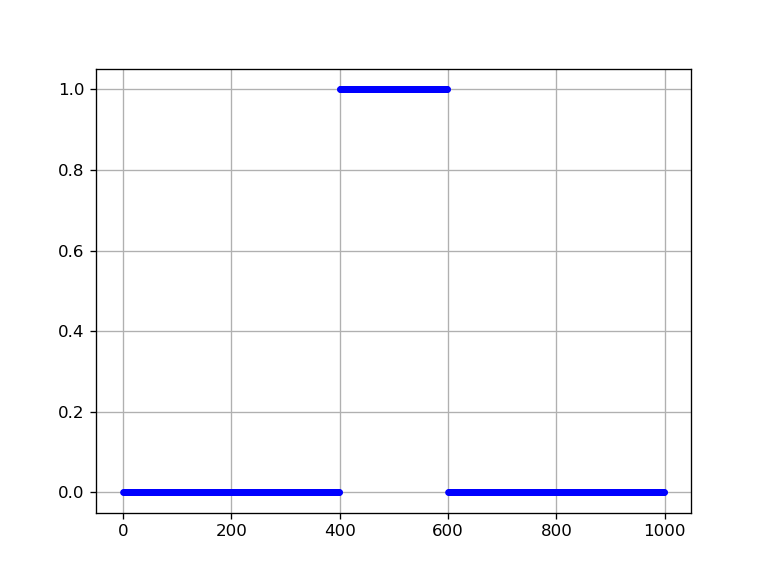

<IPython.core.display.Javascript object>


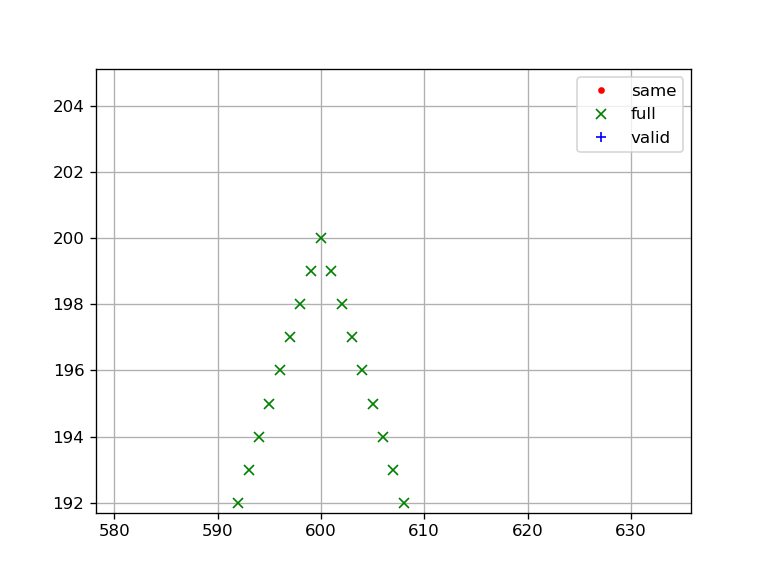

In [61]:
# signal processing tests

import numpy as np
import matplotlib.pyplot as plt

t = np.arange(0, 1, 0.001)
x = np.zeros(t.shape)
x[400:600] = 1.0

template = np.ones(201)
template[-1] = 0.0

result = np.convolve(x, np.flipud(template), mode='same')
resultFull = np.convolve(x, np.flipud(template), mode='full')
resultValid = np.convolve(x, np.flipud(template), mode='valid')

plt.figure()
# plt.plot(t, x, 'b.')
plt.plot(x, 'b.')
plt.grid()

plt.figure()
plt.plot(result, 'r.', label="same")
# plt.plot(t, result, 'r.')
plt.plot(resultFull, 'gx', label="full")
plt.plot(resultValid, 'b+', label="valid")
plt.legend()
plt.grid()

plt.show()